This Code Tries to see if `representational similarity` is correlated with `trajectory similarity`

In [2]:
from mylib.statistic_test import *

code_id = "0863 - Test Pre-Initialization Acitvity vs. Trajectory Similarity"
loc = join(figpath, 'Dsp', code_id)
mkdir(loc)

dir_name = r"E:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results"

        E:\Data\FinalResults\Dsp\0863 - Test Pre-Initialization Acitvity vs. Trajectory Similarity is already existed!


In [3]:
def preprocess_traj(T: np.ndarray, L: int) -> np.ndarray:
    """
    Separate the trajectory data into subsegments with length L.
    
    Parameters
    ----------
    T : np.ndarray
        The trajectory data to be processed. Shape should be (N, 2).
        N is the number of points in the trajectory.
    L : int
        The length of each subsegment.

    Returns
    -------
    np.ndarray
        The processed trajectory data.
    """
    S = np.full((T.shape[0], L, T.shape[1]), np.nan)
    
    if L % 2 == 0:
        pre_l = int(L / 2) - 1
        post_l = int(L / 2)
        center_l = int(L / 2)
    else:
        pre_l = int(L / 2)
        post_l = int(L / 2)
        center_l = int(L / 2) + 1
    
    extended_T = np.concatenate((np.repeat(T[0:1, :], pre_l, axis=0), T, np.repeat(T[-1:, :], post_l, axis=0)), axis=0)
    
    for i in range(T.shape[0]):
        S[i, :, :] = extended_T[i:i+L, :]
    
    # Align the first position
    for i in range(S.shape[0]):
        S[i, :, :2] -= S[i, center_l:center_l+1, :2]
        
    # Compute the first angles
    A = np.zeros(S.shape[0])
    for i in range(S.shape[0]):
        A[i] = np.arctan2(S[i, center_l+1, 1], S[i, center_l+1, 0])
    
    # Rotate back
    for i in range(S.shape[0]):
        S[i, :, :] = np.dot(S[i, :, :], np.array([[np.cos(-A[i]), np.sin(-A[i])],
                                                  [-np.sin(-A[i]), np.cos(-A[i])]]))
    return S

# Example Trajectory

        E:\Data\FinalResults\Dsp\0863 - Test Pre-Initialization Acitvity vs. Trajectory Similarity\Maze Self-Similarity is already existed!
(33502, 7, 2) (2, 33502)


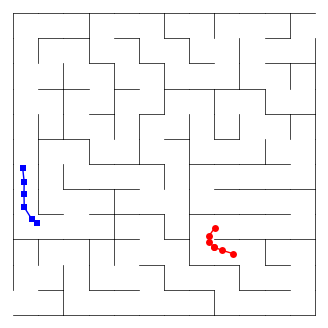

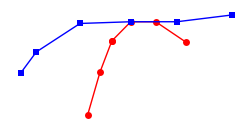

In [4]:
dir_name0 = join(loc, "Maze Self-Similarity")
mkdir(dir_name0)

def get_data(mouse: int, session: int):
    with open(join(dir_name, f"{mouse}_{np.where(f2['MiceID'] == mouse)[0][session]}.pkl"), 'rb') as f:
        return pickle.load(f)

(
    pos_traj,
    nodes_traj,
    speed_traj,
    smoothed_speed_traj,
    cumlen_traj,
    time_traj,
    lap_traj,
    route_traj,
    perfect_traj,
    raw_traj,
                    
    loss_traj,
    smoothed_loss_traj,
    decoded_nodes_traj,
    retriv_state_traj
) = get_data(10232, 6)

beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj)]])

S = np.concatenate([preprocess_traj(pos_traj[:, beg[i]:end[i]].T, L=7) for i in range(len(beg))], axis=0)

print(S.shape, pos_traj.shape)

fig = plt.figure(figsize=(4, 4))
ax = Clear_Axes(plt.axes())
DrawMazeProfile(axes=ax, maze_type=1, color='k', linewidth=0.5)
i = 96
ax.plot(pos_traj[0, i-3:i+4]/2-0.5, pos_traj[1, i-3:i+4]/2-0.5, marker='o', markersize=5, markeredgewidth=0, color='r', linewidth=1)
j = 1265
ax.plot(pos_traj[0, j-3:j+4]/2-0.5, pos_traj[1, j-3:j+4]/2-0.5, marker='s', markersize=5, markeredgewidth=0, color='b', linewidth=1)
ax.set_aspect('equal')
plt.savefig(join(loc, 'illustrator.png'), dpi=600)
plt.savefig(join(loc, 'illustrator.svg'), dpi=600)
plt.show()

fig = plt.figure(figsize=(3, 1.5))
ax = Clear_Axes(plt.axes())
ax.plot(S[i, :, 0], S[i, :, 1], marker='o', markersize=5, markeredgewidth=0, color='r', linewidth=1)
ax.plot(S[j, :, 0], S[j, :, 1], marker='s', markersize=5, markeredgewidth=0, color='b', linewidth=1)
ax.set_aspect('equal')
plt.savefig(join(loc, 'illustrator2.png'), dpi=600)
plt.savefig(join(loc, 'illustrator2.svg'), dpi=600)
plt.show()

In [45]:
def get_centroid_traj(S: np.ndarray, nodes_traj: np.ndarray, route_traj: np.ndarray, L: int) -> np.ndarray:
    centroids = np.zeros((144, L, 2), dtype=np.float64) * np.nan
    
    for b in CP_DSP[0]:
        segments_in_bin = np.where((np.isin(S2F[nodes_traj-1], b))&(route_traj == 0))[0]
        if len(segments_in_bin) > 0:
            centroids[b-1, :, :] = np.mean(S[segments_in_bin, :, :], axis=0)
        else:
            centroids[b-1, :, :] = np.nan
    return centroids

def decoding_vs_traj_similarity(mouse: int, session: int, L: int = 7) -> tuple[np.ndarray, np.ndarray]:
    (
        pos_traj,
        nodes_traj,
        speed_traj,
        smoothed_speed_traj,
        cumlen_traj,
        time_traj,
        lap_traj,
        route_traj,
        perfect_traj,
        raw_traj,
                    
        loss_traj,
        smoothed_loss_traj,
        decoded_nodes_traj,
        retriv_state_traj
    ) = get_data(mouse, session)

    beg = np.concatenate([[0], np.where(np.diff(lap_traj) != 0)[0] + 1])
    end = np.concatenate([np.where(np.diff(lap_traj) != 0)[0] + 1, [len(lap_traj
                                                                        )]])

    S = np.concatenate([preprocess_traj(pos_traj[:, beg[i]:end[i]].T, L=L) for i in range(len(beg))], axis=0)
    centroids = get_centroid_traj(S, nodes_traj, route_traj=route_traj, L=L)

    traj_dist = np.zeros(6)
    traj_dist_shuf = np.zeros((6, 1000))
    route = np.zeros(6)
    
    for r in range(1, 7):
        clear_idx = np.where((route_traj == r)&(retriv_state_traj==0)&(loss_traj > 10))[0]
    
        nodes_prer = nodes_traj[clear_idx]
        decoded_nodes_prer = decoded_nodes_traj[clear_idx]
        route0_bins = nodes_traj[route_traj == 0]
        p0 = np.histogram(S2F[route0_bins-1], bins=144, range=(0.5, 144.5))[0]
        p0 = p0[CP_DSP[0]-1]
        p0 = p0 / np.sum(p0)
        
        S_prer = S[clear_idx, :, :]
        S_ctrl = centroids[S2F[decoded_nodes_prer-1]-1, :, :]
        
        traj_dist[r-1] = np.nanmean(np.max(np.sqrt(np.sum((S_prer - S_ctrl) ** 2, axis=2)), axis=1))
        for i in range(1000):
            traj_dist_shuf[r-1, i] = np.nanmean(np.max(np.sqrt(np.sum((S_prer - centroids[np.random.choice(CP_DSP[0], size=S_prer.shape[0], p=p0)-1, :, :]) ** 2, axis=2)), axis=1))
        route[r-1] = r

    shuf_level = np.mean(traj_dist_shuf, axis=1)
    return traj_dist/shuf_level, np.ones_like(shuf_level), route

if exists(join(figdata, f"{code_id}  [Representational vs. Behavioral Similarity].pkl")) == False:
    SimData = {
        'MiceID': [],
        'Session': [],
        'Distance': [],
        'Route': [],
        'Type': []
    }
    
    for mouse in [10212, 10224, 10227, 10232]:
        for s in range(7):
            print(f"Mouse {mouse} Session {s}")
            traj_dist, traj_dist_shuf, route = decoding_vs_traj_similarity(mouse, s, L=7)
            SimData['MiceID'].append(np.repeat(mouse, len(traj_dist)*2))
            SimData['Session'].append(np.repeat(s, len(traj_dist)*2))
            SimData['Distance'].append(np.concatenate([traj_dist, traj_dist_shuf]))
            SimData['Type'].append(np.concatenate([np.repeat('Real', len(traj_dist)), np.repeat('Shuffled', len(traj_dist_shuf))]))
            SimData['Route'].append(np.concatenate([route, route]))
            
    for k in SimData.keys():
        SimData[k] = np.concatenate(SimData[k])
    
    with open(join(figdata, f"{code_id} [Representational vs. Behavioral Similarity].pkl"), 'wb') as f:
        pickle.dump(SimData, f)
        
    SimD = pd.DataFrame(SimData)
    SimD.to_excel(join(figdata, f"{code_id} [Representational vs. Behavioral Similarity].xlsx"), index=False)
    print(len(SimD))
else:
    with open(join(figdata, f"{code_id} [Representational vs. Behavioral Similarity].pkl"), 'rb') as f:
        SimData = pickle.load(f)

SubData = SubDict(SimData, SimData.keys(), np.where(SimData['Session'] == 0)[0])
fig = plt.figure(figsize=(3, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Route',
    y='Distance',
    hue='Type',
    data=SubData,
    palette=[DSPPalette[1], 'grey', DSPPalette[2], 'grey', DSPPalette[3], 'grey', DSPPalette[4], 'grey', DSPPalette[5], 'grey', DSPPalette[6], 'grey'],
    size=3,
    jitter=0,
    dodge=True,
    edgecolor='k',
    linewidth=0.2,
    legend=False,
    zorder=1
)
sns.barplot(
    x='Route',
    y='Distance',
    hue='Type',
    data=SubData,
    alpha=0.5,
    capsize=0.4, 
    err_kws={'linewidth': 0.5, 'color':'k'},
    gap=0.2,
    legend=False,
)
ax.axhline(1, color='k', linestyle='--', linewidth=0.5)
ax.set_ylim(0.6, 1.4)
ax.set_yticks(np.linspace(0.6, 1.4, 5))
for i in range(1, 7):
    SubData = SubDict(SimData, SimData.keys(), np.where((SimData['Route'] == i)&(SimData['Session'] == 0))[0])
    res = ttest_1samp(
        SubData['Distance'][(SubData['Type'] == 'Real')],
        1,
    )
    print(f"R{i}: {res}")

Mouse 10212 Session 0
Mouse 10212 Session 1
Mouse 10212 Session 2
Mouse 10212 Session 3
Mouse 10212 Session 4
Mouse 10212 Session 5
Mouse 10212 Session 6
Mouse 10224 Session 0
Mouse 10224 Session 1
Mouse 10224 Session 2
Mouse 10224 Session 3
Mouse 10224 Session 4
Mouse 10224 Session 5
Mouse 10224 Session 6
Mouse 10227 Session 0
Mouse 10227 Session 1
Mouse 10227 Session 2
Mouse 10227 Session 3
Mouse 10227 Session 4
Mouse 10227 Session 5
Mouse 10227 Session 6
Mouse 10232 Session 0
Mouse 10232 Session 1
Mouse 10232 Session 2
Mouse 10232 Session 3
Mouse 10232 Session 4
Mouse 10232 Session 5
Mouse 10232 Session 6
336


C:\Users\12454\AppData\Local\Temp\ipykernel_15544\1540647653.py:98: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.stripplot(


R1: TtestResult(statistic=-2.789187933786227, pvalue=0.06846506981869381, df=3)
R2: TtestResult(statistic=-2.5009132107540477, pvalue=0.08763606968214434, df=3)
R3: TtestResult(statistic=-5.038848937772352, pvalue=0.015069101005348345, df=3)
R4: TtestResult(statistic=-2.33237041951174, pvalue=0.10192735614815515, df=3)
R5: TtestResult(statistic=-2.1363101551850177, pvalue=0.1222788672136219, df=3)
R6: TtestResult(statistic=-1.6116295292622145, pvalue=0.20543246773510493, df=3)


# Search For Better L Values

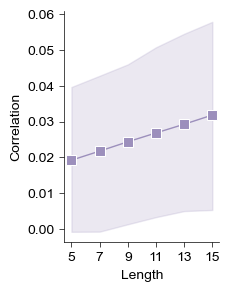

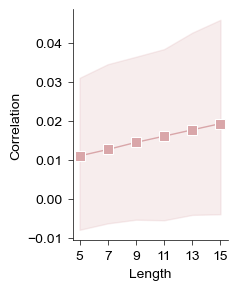

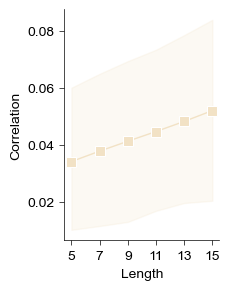

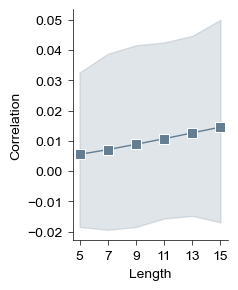

In [52]:
if exists(join(figdata, f"{code_id} [Search For Better L].pkl")) == False:
    SearchLData = {
        'MiceID': [],
        'Session': [],
        'Correlation': [],
        'Route': [],
        'Length': []
    }

    for L in range(5, 16, 2):
        print(f"Length {L} -----------------------------")
        for mouse in [10212, 10224, 10227, 10232]:
            for s in range(7):
                print(f"Mouse {mouse} Session {s}")
                correlation = analyze_neural_corr_and_traj_sim(mouse, s, L=L)
                SearchLData['MiceID'].append(np.repeat(mouse, 6))
                SearchLData['Session'].append(np.repeat(s, 6))
                SearchLData['Correlation'].append(correlation)
                SearchLData['Route'].append(np.arange(1, 7))
                SearchLData['Length'].append(np.repeat(L, 6))
        print(end='\n\n\n\n')

    for k in SearchLData.keys():
        SearchLData[k] = np.concatenate(SearchLData[k])

    with open(join(figdata, f"{code_id} [Search For Better L].pkl"), 'wb') as f:
        pickle.dump(SearchLData, f)

    SearchLData = pd.DataFrame(SearchLData)
    SearchLData.to_excel(join(figdata, f"{code_id} [Search For Better L].xlsx"), index=False)
    print(len(SearchLData))
else:
    with open(join(figdata, f"{code_id} [Search For Better L].pkl"), 'rb') as f:
        SearchLData = pickle.load(f)

for i in range(1, 7):
    SubData = SubDict(SearchLData, SearchLData.keys(), np.where(SearchLData['Route'] == i)[0])
    fig = plt.figure(figsize=(2, 3))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x='Length',
        y='Correlation',
        data=SubData,
        hue='Route',
        palette=DSPPalette[i:i+1],
        ax=ax,
        linewidth=1,
        marker='s',
        markersize=6.5,
        legend=False
    )
    ax.set_xticks(np.arange(5, 16, 2))
    plt.savefig(join(loc, f"Search For Better L - Route {i}.png"), dpi=600)
    plt.savefig(join(loc, f"Search For Better L - Route {i}.svg"), dpi=600)
    plt.show()

In [26]:
print(CP_DSP[0][11:15])
print(CP_DSP[0][27:32])
print(CP_DSP[0][37:42])
print(CP_DSP[0][58:60])
print(CP_DSP[0][68:70])
print(CP_DSP[0][95:98])
print(CP_DSP[0][104:107])

[17 29 30 31]
[32 44 45 46 47]
[56 68 69 70 71]
[55 54]
[51 39]
[124 136 137]
[129 141 142]


In [55]:
B = get_B(10232, 6)

# Spring model-based layout
import networkx as ntx

def plot_graph(B: np.ndarray):
    """
    Plot the graph using a spring model-based layout.
    
    Parameters
    ----------
    B : np.ndarray
        The adjacency matrix of the graph.
    title : str
        The title of the plot.
    """
    G = ntx.from_numpy_array(B)
    pos = ntx.spring_layout(G, seed=42)  # positions for all nodes

    fig, ax = plt.subplots(figsize=(10, 10))
    ntx.draw(G, pos, ax=ax, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
    plt.show()
    
plot_graph(B)

100%|██████████| 110/110 [00:06<00:00, 16.18it/s]


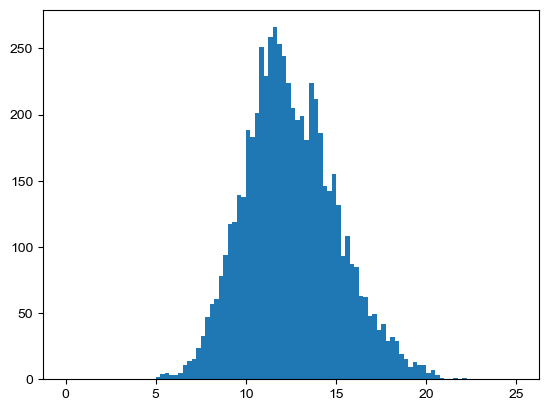

In [31]:
plt.hist(B[np.triu_indices(B.shape[0], k=1)], range=(0, 25), bins=100)
plt.show()

In [28]:
from umap.umap_ import UMAP

umap_model = UMAP(n_components=2)
S_umap = umap_model.fit_transform(S_warp)

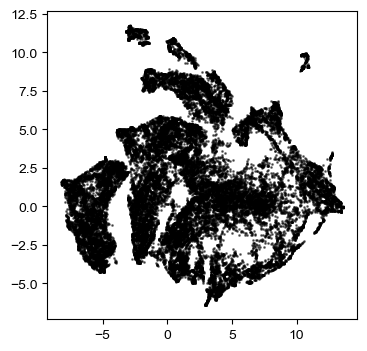

In [29]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(S_umap[:, 0], S_umap[:, 1], s=1, c='k', alpha=0.5)
plt.show()